## Project Scope

The purpose of this project is a simple proof of knowledge of key data analysis/science skills learned through Google's advanced data analytics course and independent self guided studying. This will be accomplished by analyzing a synthetic dataset of credit card transactions sourced from Kaggle and creating a machine learning model to predict fraudulent transactions.

Dataset link: https://www.kaggle.com/datasets/bhadramohit/credit-card-fraud-detection

## Milestone Goals

Look to incorporate the PACE framework plan, similar to the scientific method;

1. Plan:
    * Research relevant information; what constitutes credit card fraud? How is it commonly detected?
    * Familiarize myself with dataset. Clean data. Are there extreme outliers? Missing data?
    * Refine project scope, develop workplan.
2. Analyze:
    * Format the dataset. Label encoding? Class balancing? Normal distributions?
    * Visualize and analyze the dataset. Obvious correlations? Consider data homogeneity, feature correlation, etc...
3. Construct:
    * Feature selection, isolate outcome variable and split data to train model.
    * Build the model. Looking to refine random forest modelling skills.
        * Define, fit, and run each optimized model after cross validation. Collect scores.
        * For the sake of computing time and comparison, may consider XGBoost as well.
    * Determine champion model. Complete feature engineering and rerun, if sensible.
    * Collect predictive results.
4. Execute:
   * Generate visuals of model results on testing set.
   * Deliver executable highlighting key findings, potential model revisions, and business solutions.


## 1. Plan

Import dataset and relevant libraries.

In [ ]:
# Data storage and manipulation
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# For models
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics & other planned functions
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [187]:
# load and observe dataset
data = pd.read_csv('credit_card_fraud_dataset.csv')
data.head(5)

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [48]:
data.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,2497.092666,501.676070,0.010000
std,28867.657797,1442.415999,288.715868,0.099499
min,1.000000,1.050000,1.000000,0.000000
25%,25000.750000,1247.955000,252.000000,0.000000
50%,50000.500000,2496.500000,503.000000,0.000000
75%,75000.250000,3743.592500,753.000000,0.000000
max,100000.000000,4999.770000,1000.000000,1.000000


#### Initial thoughts:

* Label encoding to investigate fraud rates by location to identify hotspots? Can also run a scan by dates to observe relationships there, probably by date/time binning into year/month/week.
* Merchants ranging from 1 - 1000 but looks like a couple are missing based on percentiles. Erroneous maybe? Probably not indicative of much, and not worth worrying about.
* `Transaction limit looks to be $5,000. Overall quite high transactions, ~$2500 transactions on average?!`Could be indicative of a number of things. Affluent sampling pool or very large transactions from fraudsters?
* Fraud rate of 1% based on mean of IsFraud variable, 1,000 fraudulent transactions. This is an imbalanced class. Want a maximum 80:20 split, may be important to experiment with ratio to improve model performance. Consider oversampling, undersampling, and class weighting?
* Hunch tells me ['Amount'] will be the best indicator of IsFraud.

## 2. Analyze

Ensure data cleanliness.

In [ ]:
data.isna().sum()
# no missing entries

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

In [50]:
data.duplicated().sum()
# no duplicated data

np.int64(0)

In [188]:
# outlier check
percentile25 = data["Amount"].quantile(0.25)
percentile75 = data["Amount"].quantile(0.75)
iqr = percentile75 - percentile25

print("25th percentile:", percentile25)
print("75th percentile:", percentile75)
print("IQR:", iqr)

# standard technique using upper and lower bounds to detect extreme outliers not applicable; 
# transaction limit of $5,0000 surpassed when Q3 + 1.5*IQR AND Q1 - 1.5*IQR yields negative
# checking a few manually...

print(data['Amount'].sort_values(ascending=0).head(10))

25th percentile: 1247.955
75th percentile: 3743.5925
IQR: 2495.6375000000003
37148    4999.77
86214    4999.73
43484    4999.73
24372    4999.70
86525    4999.52
31354    4999.51
89560    4999.48
8262     4999.42
41320    4999.21
64229    4999.19
Name: Amount, dtype: float64


The above leads me to believe there are no true outliers (by adjusting n= in last head statement, and standard IQR method for outlier detection). Will verify a normal distribution of data['Amount] values as I suspect this will be the best predictor of credit card fraud.

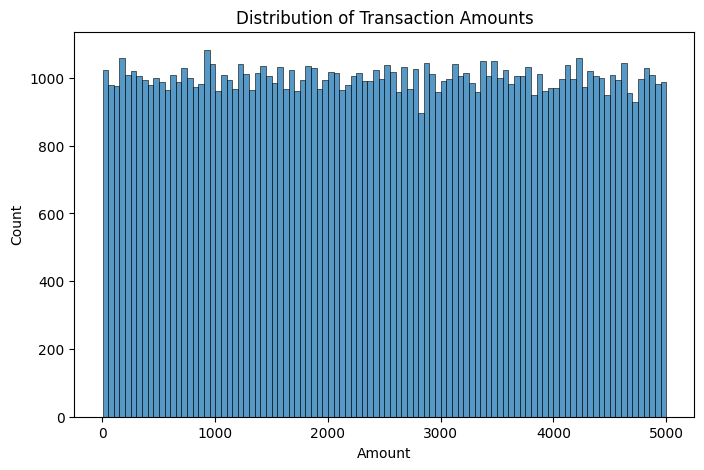

In [52]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Amount'], bins=100)
plt.title("Distribution of Transaction Amounts")
plt.show()

Uniform distribution of data. Will need to consider how this affects model performance.

Check class balances:

In [189]:
data["Location"].value_counts()              
# uniform distribution across locations

Location
Chicago         10193
San Diego       10111
Dallas          10076
San Antonio     10062
New York         9993
Houston          9991
Phoenix          9960
Los Angeles      9936
Philadelphia     9873
San Jose         9805
Name: count, dtype: int64

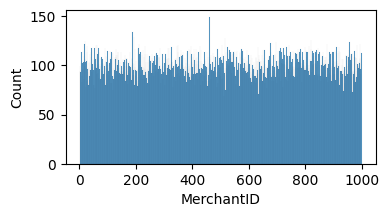

In [192]:
plt.figure(figsize=(4,2))
sns.histplot(data=data, x="MerchantID", bins=1000) # silly way to do this, but uniform-ish distribution across vendors! if it isn't broke...
plt.show()

Reasonably confident that there are no outliers in this dataset and the values in this dataset are approximately uniformly distributed. These distributions may weaken the estimating power of the model, which may be considered after training it first with the uniform distributions, as a proof of concept. Uniform distributions are uncommon in financial datasets from what I read. Curious to see how a random forest performs against one.

## 2. Analyze
Analyze feature relationships visually. Again, assuming the model handles data uniformity and class imbalances temporarily.

In [55]:
data.head(3)

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0


Feature extraction for the TransactionDate column to year/month/day/hour columns. Maybe there was a string of fraudulent events at a certain date? Also label encode TranscationType.

Will label encode the locations later. Having them in string format may be better for visualizations as I analyze the dataset.

In [56]:
data_enc = data.copy()

In [57]:
data_enc["TransactionDate"] = pd.to_datetime(data_enc["TransactionDate"])

data_enc["Year"] = data_enc["TransactionDate"].dt.year
data_enc["Month"] = data_enc["TransactionDate"].dt.month
data_enc["Day"] = data_enc["TransactionDate"].dt.day
data_enc["Hour"] = data_enc["TransactionDate"].dt.hour
data_enc = data_enc.drop(columns=["TransactionDate"])


In [58]:
data_enc.head()

,TransactionID,Amount,MerchantID,TransactionType,Location,IsFraud,Year,Month,Day,Hour
0,1,4189.27,688,refund,San Antonio,0,2024,4,3,14
1,2,2659.71,109,refund,Dallas,0,2024,3,19,13
2,3,784.00,394,purchase,New York,0,2024,1,8,10
3,4,3514.40,944,purchase,Philadelphia,0,2024,4,13,23
4,5,369.07,475,purchase,Phoenix,0,2024,7,12,18


In [59]:
data_enc["Year"].value_counts()   # making sure year worth keeping. 20% of data from 2023, so yes

Year
2024    80449
2023    19551
Name: count, dtype: int64

In [60]:
data_enc["TransactionType"] = data_enc["TransactionType"].map({"refund": 0, "purchase": 1})
data_enc.head()

,TransactionID,Amount,MerchantID,TransactionType,Location,IsFraud,Year,Month,Day,Hour
0,1,4189.27,688,0,San Antonio,0,2024,4,3,14
1,2,2659.71,109,0,Dallas,0,2024,3,19,13
2,3,784.00,394,1,New York,0,2024,1,8,10
3,4,3514.40,944,1,Philadelphia,0,2024,4,13,23
4,5,369.07,475,1,Phoenix,0,2024,7,12,18


Create visualizations based on initial hunches; amount and location type of interest.

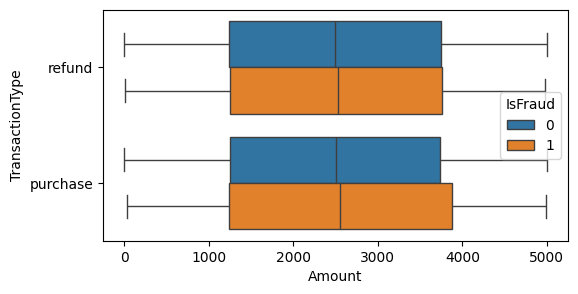

In [ ]:
plt.figure(figsize=(6,3))
sns.boxplot(data=data, x="Amount", y="TransactionType", hue="IsFraud")
plt.show()

# higher value purchases are slightly more likely to be fraudulent.

A fraud only data subset will be valuable to observe trends in fraudulent transactions.

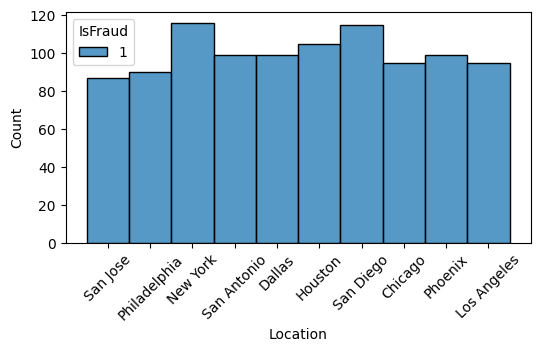

In [62]:
data_fraud_only = data_enc[data_enc['IsFraud'] == 1]
plt.figure(figsize=(6,3))
plt.xticks(rotation=45)
sns.histplot(data=data_fraud_only, x="Location", hue="IsFraud", multiple="dodge", )
plt.show()

# Looks like San Diego and New York are more susceptible to fraud. Could be a valuable indicator?

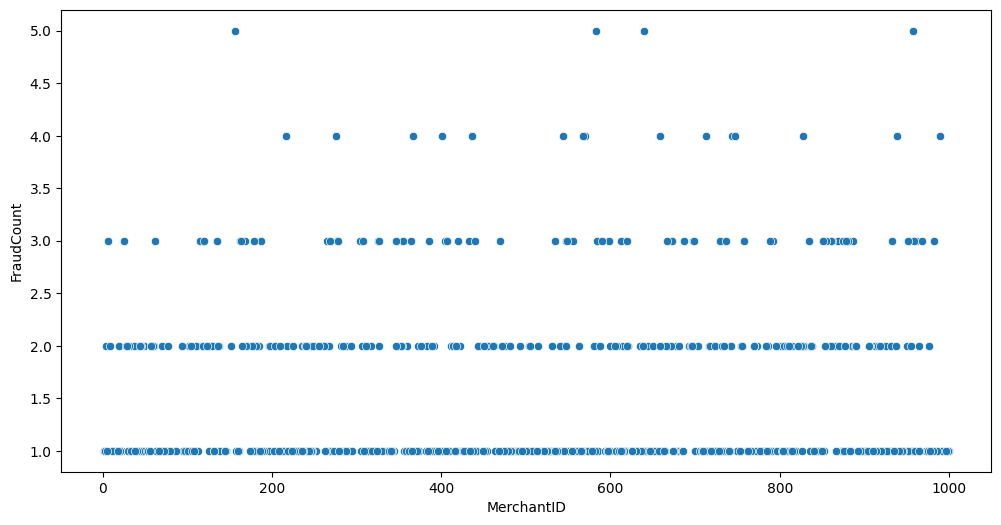

In [ ]:

fraud_counts = data_fraud_only["MerchantID"].value_counts().reset_index()
fraud_counts.columns = ["MerchantID", "FraudCount"]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=fraud_counts, x="MerchantID", y="FraudCount",)
plt.show()

# looks inconspicuous. a reasonable distribution of fraud counts by vendor, none seem complicit with fraud. higher fraud counts at a few places
# to be expected, by chance

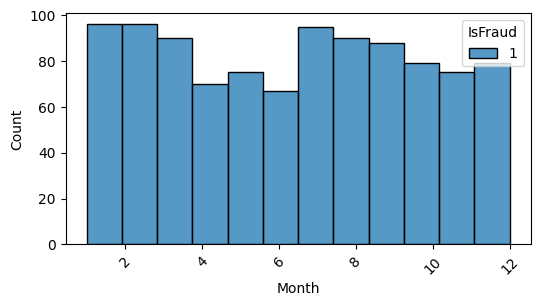

In [64]:
# is there ...seasonal fraud?

plt.figure(figsize=(6,3))
plt.xticks(rotation=45)
sns.histplot(data=data_fraud_only, x="Month", hue="IsFraud", multiple="dodge", bins=12)
plt.show()

# looks like fraud less likely in april and june

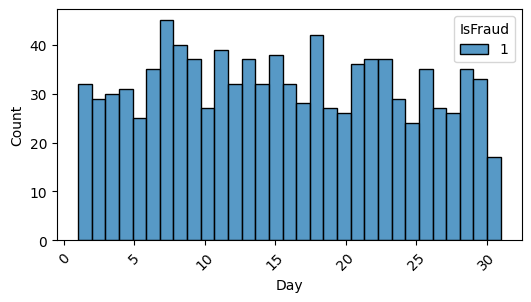

In [65]:
# maybe fraud happens more frequently on weekends?

plt.figure(figsize=(6,3))
plt.xticks(rotation=45)
sns.histplot(data=data_fraud_only, x="Day", hue="IsFraud", multiple="dodge", bins=31)
plt.show()

# does not look to be dependent on any weekday by visual scanning in increments of 7

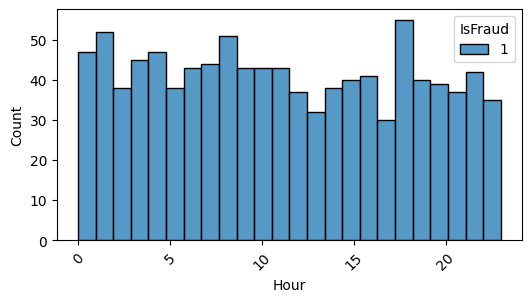

In [66]:
# How about time of day?

plt.figure(figsize=(6,3))
plt.xticks(rotation=45)
sns.histplot(data=data_fraud_only, x="Hour", hue="IsFraud", multiple="dodge", bins=24)
plt.show()

# most common fraud time is between 7 and 8 pm. 2 and 9 am also of significance.

So far, concluding that there does not appear to be a strong correlation between date features and fraudulent transactions. Will try to prove looking at TransactionIDs in cell below...

 Hypothesizing that date will not be the best estimator until I run the model and see the best estimators.

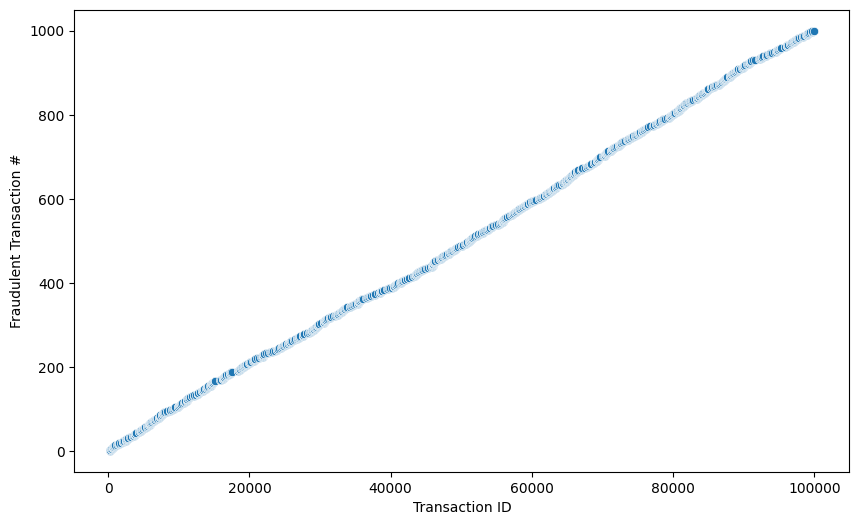

In [197]:
# check for high density of fraudulent transactions by transaction ID. perhaps fraud burst by ID??
# know from planning that dataset only has 1000 fraudulent IDs, can set the range as such

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_fraud_only, y=range(1, 1001), x='TransactionID')
plt.xlabel("Transaction ID")
plt.ylabel("Fraudulent Transaction #")
plt.show()

Proving difficult to visualize meaningful trends in this dataset, likely due to its fabricated nature. As a last effort I'll generate a heatmap using the correlations between features.

In [68]:
data_enc.head()

,TransactionID,Amount,MerchantID,TransactionType,Location,IsFraud,Year,Month,Day,Hour
0,1,4189.27,688,0,San Antonio,0,2024,4,3,14
1,2,2659.71,109,0,Dallas,0,2024,3,19,13
2,3,784.00,394,1,New York,0,2024,1,8,10
3,4,3514.40,944,1,Philadelphia,0,2024,4,13,23
4,5,369.07,475,1,Phoenix,0,2024,7,12,18


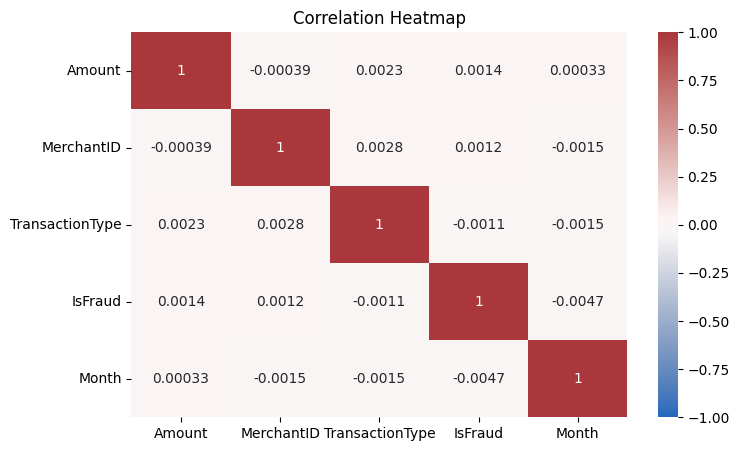

In [202]:
heatmap_subset = data_enc[["Amount", "MerchantID", "TransactionType", "IsFraud", "Month"]]

plt.figure(figsize=(8,5))
heatmap = sns.heatmap(heatmap_subset.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap')
plt.show()

While the correlations are all extremely weak, it still seems "Amount" is most strongly correlated with fraud. Will proceed with building the model keeping this in mind. Will also OneHotEncode the location column for the model before proceeding.

Based on the above, the uniform distribution of many of the features suggests significant feature overlap between the two of the target variable IsFraud. This may necessitate heightened model complexity or data preprocessing (normalization, upsampling) to facilitate easier distinction between the two classes, especially considering the class imbalance.

## 3. Construct

Feature selection based on analysis stage.

In [ ]:
data_enc = data_enc.drop(columns=["TransactionID", "Year", "Day", "Hour"])
# retaining the month column just to have 1 temporal feature

In [71]:
data_enc.head()

,Amount,MerchantID,TransactionType,Location,IsFraud,Month
0,4189.27,688,0,San Antonio,0,4
1,2659.71,109,0,Dallas,0,3
2,784.00,394,1,New York,0,1
3,3514.40,944,1,Philadelphia,0,4
4,369.07,475,1,Phoenix,0,7


OneHotEncode Location column for use in the model.

In [72]:
data_enc["Location"].unique()

encoder = OneHotEncoder(sparse_output=False)

loc_encoded = encoder.fit_transform(data_enc[["Location"]])

loc_encoded_df = pd.DataFrame(loc_encoded, columns=encoder.get_feature_names_out(["Location"]))

data_enc = pd.concat([data_enc, loc_encoded_df], axis=1)

data_enc.drop(columns=["Location"], inplace=True)

In [ ]:
data_enc.head()

,Amount,MerchantID,TransactionType,IsFraud,Month,Location_Chicago,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,Location_San Diego,Location_San Jose
0,4189.27,688,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2659.71,109,0,0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,784.00,394,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3514.40,944,1,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,369.07,475,1,0,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Prepare data for modelling, define target variable.

In [ ]:
y = data_enc["IsFraud"]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: IsFraud, dtype: int64

In [75]:
X = data_enc.drop("IsFraud", axis=1)
X.head()

,Amount,MerchantID,TransactionType,Month,Location_Chicago,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,Location_San Diego,Location_San Jose
0,4189.27,688,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2659.71,109,0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,784.00,394,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3514.40,944,1,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,369.07,475,1,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Lastly, need to address class imbalance in target variable IsFraud. A ratio of 99:1 is not acceptable. Looking to upsample to an IsFraud class balance of 80:20 with SMOTE. Running only on training set to preserve 'real-world' conditions of testing set.

In [77]:
smote = SMOTE(sampling_strategy = 0.2, random_state=42)

X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train, y_train)

In [78]:
print("Raw data:\n", y_train.value_counts())
print("Oversampled data:\n", y_train_upsampled.value_counts())

Raw data:
 IsFraud
0    74250
1      750
Name: count, dtype: int64
Oversampled data:
 IsFraud
0    74250
1    14850
Name: count, dtype: int64


Must consider (ethical) implications of model results. Obviously want to maximize true positives. Must consider: false positives would be problematic, costly to company + bad for clientele trust in company. However, false negatives are of seemingly greater importance from business perspective; fraud going undetected. Makes f1 score an appealing scoring metric, to balance the two (consider precision, recall). 

Intentionally left the IsFraud classes imbalanced (80:20 split) as one would expect imbalance in a real dataset. This makes the roc_auc score appealing as well. Class distinction is critical. Will refit model using f1 score to start, looking to balance precision and recall to start. Adding to this by applying class_weight parameter to RandomForestClassifier to penalize misclassificatying fraudulent transactions.

In [ ]:
# define, instantiate model

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

cv_params = {'max_depth': [3,5,None],
             'max_features': [None, 'sqrt', 'log2'],
             'max_samples': [0.7,1],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,4],
             'n_estimators': [100,200]}

scoring = {"precision": "precision", "recall": "recall", "accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

rf_f1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit="f1", verbose=1, n_jobs=-1)

In [ ]:
%%time
rf_f1.fit(X_train_upsampled, y_train_upsampled)

# output indicative of ill-defined precision. problem with estimation of minority class impending?!

In [ ]:
import copy
rf_f1_results = copy.deepcopy(rf_f1)

# in the event I overwrite the rf_f1 variable

In [82]:
import pickle
import os
path = os.getcwd()

Define pickling process to expedite modelling across sessions.

In [ ]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         folder for pickle storing
        model_object: model to be pickled
        save_as:      filename 

    Out: A call to pickle the model in path
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path
        saved_model_name: file name

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [85]:
write_pickle(path, rf_f1, "rf_f1_results")

In [ ]:
rf_f1 = read_pickle(path, "rf_f1_results")

Verify integrity of model results. Interpret them.

In [87]:
rf_f1_dataframe = pd.DataFrame(rf_f1.cv_results_)
pd.set_option("display.max_columns", None)
rf_f1_dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,9.468273,0.089855,0.289904,0.025258,3,None,0.7,1,2,100,"{'max_depth': 3, 'max_features': None, 'max_sa...",0.302933,0.292671,0.322165,0.289012,0.301695,0.012873,69,0.759698,0.840248,0.841637,0.826017,0.816900,0.033587,53,0.668642,0.634972,0.678429,0.632278,0.653580,0.020275,141,0.433146,0.434129,0.465966,0.428202,0.440361,0.014953,69,0.780545,0.856451,0.857639,0.864664,0.839825,0.034369,71
1,17.280265,0.105307,0.341865,0.008535,3,None,0.7,1,2,200,"{'max_depth': 3, 'max_features': None, 'max_sa...",0.302933,0.296894,0.326986,0.289012,0.303956,0.014183,65,0.759698,0.857489,0.860221,0.826017,0.825856,0.040492,49,0.668642,0.637845,0.681571,0.632278,0.655084,0.020632,137,0.433146,0.441073,0.473852,0.428202,0.444068,0.017798,65,0.784085,0.875587,0.866994,0.877296,0.850991,0.038824,65
2,7.776015,0.089312,0.192589,0.002122,3,None,0.7,1,4,100,"{'max_depth': 3, 'max_features': None, 'max_sa...",0.302933,0.292671,0.322165,0.289012,0.301695,0.012873,69,0.759698,0.840248,0.841637,0.826017,0.816900,0.033587,53,0.668642,0.634972,0.678429,0.632278,0.653580,0.020275,141,0.433146,0.434129,0.465966,0.428202,0.440361,0.014953,69,0.780545,0.856451,0.857639,0.864664,0.839825,0.034369,71
3,13.411097,0.060240,0.348607,0.034142,3,None,0.7,1,4,200,"{'max_depth': 3, 'max_features': None, 'max_sa...",0.302933,0.296894,0.326986,0.289012,0.303956,0.014183,65,0.759698,0.857489,0.860221,0.826017,0.825856,0.040492,49,0.668642,0.637845,0.681571,0.632278,0.655084,0.020632,137,0.433146,0.441073,0.473852,0.428202,0.444068,0.017798,65,0.784085,0.875587,0.866994,0.877296,0.850991,0.038824,65
4,6.736513,0.037434,0.182535,0.002575,3,None,0.7,2,2,100,"{'max_depth': 3, 'max_features': None, 'max_sa...",0.302933,0.292671,0.322165,0.289012,0.301695,0.012873,69,0.759698,0.840248,0.841637,0.826017,0.816900,0.033587,53,0.668642,0.634972,0.678429,0.632278,0.653580,0.020275,141,0.433146,0.434129,0.465966,0.428202,0.440361,0.014953,69,0.780545,0.856451,0.857653,0.864662,0.839828,0.034370,69


In [88]:
rf_f1_scores = pd.DataFrame({
            "Precision Distribution": rf_f1_dataframe["mean_test_precision"],
            "Precision rank": rf_f1_dataframe["rank_test_precision"],
            "Recall Distribution": rf_f1_dataframe["mean_test_recall"],
            "Recall rank": rf_f1_dataframe["rank_test_recall"],
            "Accuracy Distribution": rf_f1_dataframe["mean_test_accuracy"],
            "Accuracy rank": rf_f1_dataframe["rank_test_accuracy"],
            "f1 Distribution": rf_f1_dataframe["mean_test_f1"],
            "f1 rank": rf_f1_dataframe["rank_test_f1"],
            "ROC AUC Distribution": rf_f1_dataframe["mean_test_roc_auc"],
            "ROC AUC rank": rf_f1_dataframe["rank_test_roc_auc"],})

pd.set_option("display.max_rows", 10) # toggle value (to None for all) to investigate more scores. 

rf_f1_scores

,Precision Distribution,Precision rank,Recall Distribution,Recall rank,Accuracy Distribution,Accuracy rank,f1 Distribution,f1 rank,ROC AUC Distribution,ROC AUC rank
0,0.301695,69,0.816900,53,0.653580,141,0.440361,69,0.839825,71
1,0.303956,65,0.825856,49,0.655084,137,0.444068,65,0.850991,65
2,0.301695,69,0.816900,53,0.653580,141,0.440361,69,0.839825,71
3,0.303956,65,0.825856,49,0.655084,137,0.444068,65,0.850991,65
4,0.301695,69,0.816900,53,0.653580,141,0.440361,69,0.839828,69
...,...,...,...,...,...,...,...,...,...,...
139,0.000000,73,0.000000,73,0.833333,25,0.000000,73,0.500000,73
140,0.000000,73,0.000000,73,0.833333,25,0.000000,73,0.500000,73
141,0.000000,73,0.000000,73,0.833333,25,0.000000,73,0.500000,73
142,0.000000,73,0.000000,73,0.833333,25,0.000000,73,0.500000,73


In [89]:
rf_f1_dataframe["mean_test_precision"].value_counts()
# rf_f1_dataframe["mean_test_recall"].value_counts()
# rf_f1_dataframe["mean_test_accuracy"].value_counts()
# rf_f1_dataframe["mean_test_f1"].value_counts()
# rf_f1_dataframe["mean_test_roc_auc"].value_counts()

mean_test_precision
0.000000    72
0.435109     8
0.433705     8
0.301695     4
0.479338     4
            ..
0.477051     2
0.985222     1
0.986766     1
0.987220     1
0.985621     1
Name: count, Length: 25, dtype: int64

A quick glance at the results shows the model ran successfully. 144 hyperparameter combinations were tested (3*3*2*2*2*2=144), 144 result combinations were generated. Interestingly, exactly 72 (1/2) have a precision of 0 and consequently recall and f1 values of 0. Furthermore, 72 show accuracy values of 0.833333, and 72 show ROC AUC scores of of 0.5.

This is questionable as the minority class was upsampled to an 80:20 split AND the class_weight parameter was assigned to balance to weigh the minority class more heavily, ideally improving fraud detection performance. It may simply be that the feature overlap between classes is too high for the model to distinguish between classes without heightened model sensitivity by applying things like feature engineering or further hyperparameter tuning. Based on the analysis stage, this seems a likely cause. Fraudulent transactions were very similar to non-fraudulent transactions.

Hypothesis is that the synthetic nature of this dataset causes a subset of the trees where the cv_param max_samples = 1 to be unable to predict fraudulent transactions at all due to feature overlap. Further indicated via 72 accuracy scores of 0.833333, which perfectly represents the majority class; 74250 / 74250 + 14850 = 0.833333. ROC AUC readings indicate this is no better than a random guess.

In [90]:
# quick verification of hypothesis:
rf_f1_subset = rf_f1_dataframe[rf_f1_dataframe["mean_test_precision"] == 0]
print(rf_f1_subset.shape)
print(rf_f1_subset["param_max_samples"].value_counts())

(72, 46)
param_max_samples
1.0    72
Name: count, dtype: int64


Hypothesis confirmed, subset is forests where max_samples = 1. Reasons most likely to be lack of distinction between features of the 2 differing classes - at least when features are selected this way. Model improvement would be to introduce an element of randomness. Shown by successful trees having max_samples = 0.7.

In [ ]:
# write a function to quickly extract model results - note, adapted from online source

def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV object
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract metrics from best estimator
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [143]:
rf_f1_scores = make_results("rf_f1 scores", rf_f1, 'f1')
rf_f1_scores

,model,precision,recall,F1,accuracy,auc
0,rf_f1 scores,0.98722,0.928411,0.955053,0.986083,0.981996


In [93]:
rf_f1.best_params_

{'max_depth': None,
 'max_features': None,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

Overall the scores are quite good. Run model with testing set now.

In [ ]:
# Generate class predictions
predictions = rf_f1.best_estimator_.predict(X_test)

# required for roc_auc
probabilities = rf_f1.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate metrics
auc = roc_auc_score(y_test, probabilities)  # Use probabilities for AUC
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Create a results table
table = pd.DataFrame({
    "Model": ["rf_f1"],
    "AUC Score": [auc],
    "Accuracy Score": [accuracy],
    "Precision Score": [precision],
    "Recall Score": [recall],
    "F1 Score": [f1]
})

table


,Model,AUC Score,Accuracy Score,Precision Score,Recall Score,F1 Score
0,rf_auc,0.520694,0.98772,0.016949,0.004,0.006472


It appears that the model lacks adequate sensitivity to effectively distinguish between target variable classes, i.e. detect fraud. Instead of further optimizing this model, will switch focuses to an XGBoost model to see its distinction capacity with a heavily imbalanced testing set.

In [ ]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", random_state=42)

# Define hyperparameters for GridSearchCV
cv_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'scale_pos_weight': [1, 10, 20],  # To address class imbalance
    'alpha': [0.2, 1, 5]
}

scoring = {"precision": "precision", "recall": "recall", "accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

xgb_f1 = GridSearchCV(estimator=xgb, param_grid=cv_params, scoring=scoring, cv=4, verbose=1, n_jobs=-1,refit="f1")

In [ ]:
%%time
xgb_f1.fit(X_train, y_train)

In [97]:
write_pickle(path, xgb_f1, "xgb_f1_results")

In [98]:
read_pickle(path, "xgb_f1_results")

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.2, 1, 5], 'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 10, 20],
                         'subsample': [0.7, 1.0]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [99]:
xgb_f1_dataframe = pd.DataFrame(xgb_f1.cv_results_)
xgb_f1_dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_scale_pos_weight,param_subsample,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.238298,0.006079,0.045546,0.002923,0.2,0.7,0.01,3,100,1,0.7,"{'alpha': 0.2, 'colsample_bytree': 0.7, 'learn...",0.0,0.0,0.0,0.0,0.0,0.0,176,0.0,0.0,0.0,0.0,0.0,0.0,176,0.990027,0.990027,0.989973,0.989973,0.99,0.000027,1,0.0,0.0,0.0,0.0,0.0,0.0,176,0.492601,0.504947,0.506132,0.472171,0.493963,0.013652,335
1,0.205308,0.016961,0.050779,0.009435,0.2,0.7,0.01,3,100,1,1.0,"{'alpha': 0.2, 'colsample_bytree': 0.7, 'learn...",0.0,0.0,0.0,0.0,0.0,0.0,176,0.0,0.0,0.0,0.0,0.0,0.0,176,0.990027,0.990027,0.989973,0.989973,0.99,0.000027,1,0.0,0.0,0.0,0.0,0.0,0.0,176,0.490360,0.500000,0.503402,0.473621,0.491846,0.011558,395
2,0.613627,0.042107,0.122636,0.017507,0.2,0.7,0.01,3,100,10,0.7,"{'alpha': 0.2, 'colsample_bytree': 0.7, 'learn...",0.0,0.0,0.0,0.0,0.0,0.0,176,0.0,0.0,0.0,0.0,0.0,0.0,176,0.990027,0.990027,0.989973,0.989973,0.99,0.000027,1,0.0,0.0,0.0,0.0,0.0,0.0,176,0.498799,0.485422,0.492269,0.476042,0.488133,0.008432,485
3,0.581202,0.032546,0.099880,0.018762,0.2,0.7,0.01,3,100,10,1.0,"{'alpha': 0.2, 'colsample_bytree': 0.7, 'learn...",0.0,0.0,0.0,0.0,0.0,0.0,176,0.0,0.0,0.0,0.0,0.0,0.0,176,0.990027,0.990027,0.989973,0.989973,0.99,0.000027,1,0.0,0.0,0.0,0.0,0.0,0.0,176,0.515977,0.493883,0.497775,0.472359,0.494999,0.015505,294
4,0.596707,0.024646,0.112257,0.016024,0.2,0.7,0.01,3,100,20,0.7,"{'alpha': 0.2, 'colsample_bytree': 0.7, 'learn...",0.0,0.0,0.0,0.0,0.0,0.0,176,0.0,0.0,0.0,0.0,0.0,0.0,176,0.990027,0.990027,0.989973,0.989973,0.99,0.000027,1,0.0,0.0,0.0,0.0,0.0,0.0,176,0.498722,0.488780,0.486378,0.474520,0.487100,0.008612,517


In [100]:
# Best model
best_xgb = xgb_f1.best_estimator_

# Predictions and probabilities
xgb_predictions = best_xgb.predict(X_test)
xgb_probabilities = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation metrics
xgb_auc = roc_auc_score(y_test, xgb_probabilities)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1_score = f1_score(y_test, xgb_predictions)

# Results summary
results = pd.DataFrame({
    "Model": ["XGBoost"],
    "AUC Score": [xgb_auc],
    "Accuracy Score": [xgb_accuracy],
    "Precision Score": [xgb_precision],
    "Recall Score": [xgb_recall],
    "F1 Score": [xgb_f1_score]
})

print(results)


     Model  AUC Score  Accuracy Score  Precision Score  Recall Score  F1 Score
0  XGBoost   0.495012         0.98076         0.012658         0.012   0.01232


Model again seems to be no better (somehow worse???) than a random guess at predicting credit card fraud. Issue still hides in class distinction for target variable, particularly in testing set where class distribution remains 99:1. Options: 
* fine tune hyperparameters for greater sensitivity, particularly threshold tuning and sample drawing ratios (max_samples, max_features/XGB counterparts)
* modify testing set. model will not reflect 'real world class imbalance', but will certainly be better suited for flagging fraudulent transactions due to their higher frequency.

Will upsample both training and testing sets and rerun model, but retain the 80:20 class balance to reflect the inherent class imbalance.

In [101]:
X2 = X.copy()
y2 = y.copy()

In [102]:
# SMOTE instantiation remains valid

X2_upsampled, y2_upsampled = smote.fit_resample(X2, y2)

In [103]:
print(X2_upsampled.shape, y2_upsampled.shape)

(118800, 14) (118800,)


Implement addition of validation set too to ensure model robustness.

In [104]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X2_upsampled, y2_upsampled, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [105]:
print(X_trainval.shape, y_trainval.shape,'\n', X_test.shape, y_test.shape,'\n', X_train.shape, y_train.shape,'\n', X_valid.shape, y_valid.shape)

(95040, 14) (95040,) 
 (23760, 14) (23760,) 
 (76032, 14) (76032,) 
 (19008, 14) (19008,)


In [ ]:
# define, instantiate model. revise params to increase robustness?

cv_params = {'max_depth': [3,5,None],
             'max_features': ['sqrt', 'log2', None],
             'max_samples': [0.4, 0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,4],
             'n_estimators': [100,200]}

scoring = {"precision": "precision", "recall": "recall", "accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

rf_revised = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit="f1", verbose=1, n_jobs=-1)

In [107]:
%%time
rf_revised.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
CPU times: user 40.8 s, sys: 7.65 s, total: 48.4 s
Wall time: 15min 35s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.4, 0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [108]:
rf_revised_results = copy.deepcopy(rf_revised)

In [109]:
write_pickle(path, rf_revised, "rf_revised_results")

In [110]:
read_pickle(path, "rf_revised_results")

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.4, 0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [111]:
rf_revised_dataframe = pd.DataFrame(rf_revised.cv_results_)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)
print(rf_revised_dataframe.shape)
rf_revised_dataframe

(144, 51)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,2.029740,0.029820,0.139990,0.014981,3,sqrt,0.4,1,2,100,"{'max_depth': 3, 'max_features': 'sqrt', 'max_...",0.452093,0.535732,0.481884,0.471122,0.486328,0.485432,0.027784,81,0.896186,0.830975,0.836807,0.837200,0.846245,0.849482,0.023857,105,0.801013,0.851253,0.822241,0.815599,0.824806,0.822982,0.016372,81,0.601002,0.651464,0.611582,0.602945,0.617681,0.616935,0.018281,81,0.922825,0.915108,0.915747,0.910406,0.916237,0.916064,0.003969,85
1,3.923935,0.099328,0.256238,0.017955,3,sqrt,0.4,1,2,200,"{'max_depth': 3, 'max_features': 'sqrt', 'max_...",0.459304,0.473081,0.425419,0.436470,0.487691,0.456393,0.022903,101,0.814392,0.811714,0.818718,0.822650,0.817932,0.817081,0.003754,121,0.808641,0.817255,0.784756,0.792713,0.825858,0.805845,0.015203,101,0.587351,0.597771,0.559903,0.570338,0.611046,0.585282,0.018393,101,0.912186,0.908795,0.908817,0.903484,0.907317,0.908120,0.002815,119
2,2.021545,0.047406,0.132084,0.009044,3,sqrt,0.4,1,4,100,"{'max_depth': 3, 'max_features': 'sqrt', 'max_...",0.452093,0.535732,0.481884,0.471122,0.486328,0.485432,0.027784,81,0.896186,0.830975,0.836807,0.837200,0.846245,0.849482,0.023857,105,0.801013,0.851253,0.822241,0.815599,0.824806,0.822982,0.016372,81,0.601002,0.651464,0.611582,0.602945,0.617681,0.616935,0.018281,81,0.922825,0.915104,0.915747,0.910406,0.916236,0.916063,0.003969,87
3,3.886644,0.046145,0.235969,0.025340,3,sqrt,0.4,1,4,200,"{'max_depth': 3, 'max_features': 'sqrt', 'max_...",0.459304,0.473081,0.425419,0.436379,0.487691,0.456375,0.022919,103,0.814392,0.811714,0.818718,0.822650,0.817932,0.817081,0.003754,121,0.808641,0.817255,0.784756,0.792648,0.825858,0.805832,0.015215,103,0.587351,0.597771,0.559903,0.570260,0.611046,0.585266,0.018405,103,0.912186,0.908798,0.908817,0.903484,0.907317,0.908120,0.002815,117
4,1.978167,0.049295,0.132838,0.006086,3,sqrt,0.4,2,2,100,"{'max_depth': 3, 'max_features': 'sqrt', 'max_...",0.452093,0.535732,0.481884,0.471122,0.486328,0.485432,0.027784,81,0.896186,0.830975,0.836807,0.837200,0.846245,0.849482,0.023857,105,0.801013,0.851253,0.822241,0.815599,0.824806,0.822982,0.016372,81,0.601002,0.651464,0.611582,0.602945,0.617681,0.616935,0.018281,81,0.922825,0.915105,0.915766,0.910404,0.916233,0.916066,0.003970,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,44.894166,0.148026,1.012689,0.023168,None,None,0.7,1,4,200,"{'max_depth': None, 'max_features': None, 'max...",0.990184,0.983885,0.987660,0.992337,0.988927,0.988598,0.002818,43,0.912308,0.911950,0.912702,0.916634,0.913095,0.913338,0.001692,5,0.983823,0.982771,0.983493,0.984874,0.983756,0.983744,0.000677,2,0.949652,0.946552,0.948702,0.952984,0.949499,0.949478,0.002073,2,0.981920,0.974878,0.977628,0.979357,0.977378,0.978232,0.002333,22
140,22.397791,0.089420,0.511119,0.012478,None,None,0.7,2,2,100,"{'max_depth': None, 'max_features': None, 'max...",0.988931,0.980144,0.984295,0.988156,0.987239,0.985753,0.003215,47,0.913488,0.911950,0.911915,0.918600

In [112]:
rf_revised_scores = pd.DataFrame({
            "Precision Distribution": rf_revised_dataframe["mean_test_precision"],
            "Precision rank": rf_revised_dataframe["rank_test_precision"],
            "Recall Distribution": rf_revised_dataframe["mean_test_recall"],
            "Recall rank": rf_revised_dataframe["rank_test_recall"],
            "Accuracy Distribution": rf_revised_dataframe["mean_test_accuracy"],
            "Accuracy rank": rf_revised_dataframe["rank_test_accuracy"],
            "f1 Distribution": rf_revised_dataframe["mean_test_f1"],
            "f1 rank": rf_revised_dataframe["rank_test_f1"],
            "ROC AUC Distribution": rf_revised_dataframe["mean_test_roc_auc"],
            "ROC AUC rank": rf_revised_dataframe["rank_test_roc_auc"],})

pd.set_option("display.max_rows", 10) # toggle value (to None for all) to investigate more scores. 

rf_revised_scores

,Precision Distribution,Precision rank,Recall Distribution,Recall rank,Accuracy Distribution,Accuracy rank,f1 Distribution,f1 rank,ROC AUC Distribution,ROC AUC rank
0,0.485432,81,0.849482,105,0.822982,81,0.616935,81,0.916064,85
1,0.456393,101,0.817081,121,0.805845,101,0.585282,101,0.908120,119
2,0.485432,81,0.849482,105,0.822982,81,0.616935,81,0.916063,87
3,0.456375,103,0.817081,121,0.805832,103,0.585266,103,0.908120,117
4,0.485432,81,0.849482,105,0.822982,81,0.616935,81,0.916066,81
...,...,...,...,...,...,...,...,...,...,...
139,0.988598,43,0.913338,5,0.983744,2,0.949478,2,0.978232,22
140,0.985753,47,0.913731,3,0.983362,7,0.948375,7,0.978149,26
141,0.986596,45,0.914045,1,0.983546,4,0.948934,4,0.978147,28
142,0.985753,47,0.913731,3,0.983362,7,0.948375,7,0.978149,26


In [113]:
pd.set_option('display.max_rows', None)

rf_revised_dataframe["mean_test_precision"].value_counts()
# rf_revised_dataframe["mean_test_recall"].value_counts()
# rf_revised_dataframe["mean_test_accuracy"].value_counts()
# rf_revised_dataframe["mean_test_f1"].value_counts()
# rf_revised_dataframe["mean_test_roc_auc"].value_counts()

mean_test_precision
0.485432    8
0.482309    8
0.435537    8
0.683687    4
0.994373    4
0.993941    4
0.997067    4
0.996894    4
0.635784    4
0.666938    4
0.645554    4
0.356064    4
0.274984    4
0.275972    4
0.285645    4
0.456512    4
0.994730    2
0.997422    2
0.683685    2
0.281771    2
0.995924    2
0.995925    2
0.645349    2
0.998310    2
0.994722    2
0.456375    2
0.992497    2
0.992230    2
0.985753    2
0.998132    2
0.997421    2
0.353287    2
0.635527    2
0.645653    2
0.683124    2
0.667298    2
0.353265    2
0.636456    2
0.667672    2
0.986596    2
0.281789    2
0.358933    2
0.366700    2
0.358921    2
0.366732    2
0.456393    2
0.993955    1
0.992834    1
0.992915    1
0.989844    1
0.989603    1
0.987663    1
0.988598    1
0.994215    1
Name: count, dtype: int64

Some hyperparameter combinations yield poor precision in particular. Numerous false positives. Costly for a bank's fraud division! Why is this?

In [114]:
# run through hyperparameter combinations w/ poor precision

rf_revised_subset = rf_revised_dataframe[rf_revised_dataframe["mean_test_precision"] < 0.75]
print(rf_revised_subset.shape)

# recall list of hyperparams:
        #     {'max_depth': [3,5,None],
        #      'max_features': ['sqrt', 'log2', None],
        #      'max_samples': [0.4, 0.7],
        #      'min_samples_leaf': [1,2],
        #      'min_samples_split': [2,4],
        #      'n_estimators': [100,200]}

print(rf_revised_subset["param_max_features"].value_counts())
print(rf_revised_subset["param_max_depth"].value_counts())

(96, 51)
param_max_features
sqrt    32
log2    32
Name: count, dtype: int64
param_max_depth
3    48
5    48
Name: count, dtype: int64


Apparent that 2/3 of all hyperparameter combinations yielded quite poor precision (< 0.7) based on shape attribute of this subset. Based on possible combinations, had to be a hyperparameter with 3 set tuning options, max_features or max_depth. 

From above cell, the model requires a depth greater than 5 to be of value. Note that param_max_features not displaying the 32 combinations assigned to param = None. Will display the best_estimator_ later to see how deep the best model is.

In [115]:
rf_revised_scores = make_results("rf revised scores", rf_revised, 'f1')
rf_revised_scores

,model,precision,recall,F1,accuracy,auc
0,rf revised scores,0.989603,0.912944,0.949728,0.983836,0.978347


In [116]:
rf_revised.best_params_

{'max_depth': None,
 'max_features': None,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
# Generate class predictions
predictions = rf_revised.best_estimator_.predict(X_test)

# Generate probability predictions (for the positive class)
probabilities = rf_revised.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
auc = roc_auc_score(y_test, probabilities)  # Use probabilities for AUC
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Create a results table
table = pd.DataFrame({
    "Model": ["rf_f1"],
    "AUC Score": [auc],
    "Accuracy Score": [accuracy],
    "Precision Score": [precision],
    "Recall Score": [recall],
    "F1 Score": [f1]
})

table

,Model,AUC Score,Accuracy Score,Precision Score,Recall Score,F1 Score
0,rf_auc,0.980248,0.984554,0.986904,0.917141,0.950745


This model appears to be able to successfully distinguish between the classes and thus identify credit card fraud with a certain probability. Investigate further displaying results in confusion matrix.

Quickly confirm with validation split.

In [118]:
# Generate class predictions
predictions = rf_revised.best_estimator_.predict(X_valid)

# Generate probability predictions (for the positive class)
probabilities = rf_revised.best_estimator_.predict_proba(X_valid)[:, 1]

# Calculate evaluation metrics
auc = roc_auc_score(y_valid, probabilities)  # Use probabilities for AUC
accuracy = accuracy_score(y_valid, predictions)
precision = precision_score(y_valid, predictions)
recall = recall_score(y_valid, predictions)
f1 = f1_score(y_valid, predictions)

# Create a results table
table = pd.DataFrame({
    "Model": ["rf_revised"],
    "AUC Score": [auc],
    "Accuracy Score": [accuracy],
    "Precision Score": [precision],
    "Recall Score": [recall],
    "F1 Score": [f1]
})

table

,Model,AUC Score,Accuracy Score,Precision Score,Recall Score,F1 Score
0,rf_revised,0.980543,0.983481,0.986288,0.91527,0.949453


Similar results on validation split confirms that the model has effectively learned the trends that are seen in fraudulent transactions and is not suspect of significant overfitting.

Quick test on revised XGBoost model to see if it has improved as well.

In [119]:
# Define hyperparameters for GridSearchCV
cv_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.4, 0.7],
    'colsample_bytree': [0.4, 0.7],
    'scale_pos_weight': [1, 10, 20], 
    'alpha': [0.2, 1, 5]
}

# Define multiple evaluation metrics (if needed)
scoring = {"precision": "precision", "recall": "recall", "accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# GridSearchCV setup with refit based on roc_auc
xgb_revised = GridSearchCV(estimator=xgb, param_grid=cv_params, scoring=scoring,cv=5, verbose=1, n_jobs=-1, refit="f1")

In [ ]:
%%time
xgb_revised.fit(X_train, y_train)

In [121]:
write_pickle(path, xgb_revised, "xgb_revised_results")

In [122]:
read_pickle(path, "xgb_revised_results")

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.2, 1, 5], 'colsample_bytree': [0.4, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, None], 'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 10, 20],
                         'subsample': [0.4, 0.7]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [123]:
xgb_revised_dataframe = pd.DataFrame(xgb_revised.cv_results_)
xgb_revised_dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_scale_pos_weight,param_subsample,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.682825,0.045881,0.102141,0.018307,0.2,0.4,0.01,3,100,1,0.4,"{'alpha': 0.2, 'colsample_bytree': 0.4, 'learn...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,643,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,643,0.832774,0.832709,0.832763,0.832763,0.832763,0.832755,0.000023,501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,643,0.944306,0.944837,0.943100,0.943740,0.937181,0.942633,0.002787,637
1,0.659061,0.068265,0.094851,0.020395,0.2,0.4,0.01,3,100,1,0.7,"{'alpha': 0.2, 'colsample_bytree': 0.4, 'learn...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,643,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,643,0.832774,0.832709,0.832763,0.832763,0.832763,0.832755,0.000023,501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,643,0.946483,0.945282,0.945118,0.944122,0.938062,0.943813,0.002972,619
2,0.685303,0.033472,0.089219,0.004048,0.2,0.4,0.01,3,100,10,0.4,"{'alpha': 0.2, 'colsample_bytree': 0.4, 'learn...",0.167645,0.167523,0.167237,0.167237,0.167237,0.167375,0.000174,616,0.999607,1.0,1.0,1.000000,1.0,0.999921,0.000157,31,0.169988,0.168672,0.167237,0.167237,0.167237,0.168074,0.001107,622,0.287134,0.286971,0.286551,0.286551,0.286551,0.286752,0.000251,606,0.948857,0.946993,0.945742,0.945947,0.939204,0.945348,0.003264,596
3,0.628292,0.015955,0.098394,0.013777,0.2,0.4,0.01,3,100,10,0.7,"{'alpha': 0.2, 'colsample_bytree': 0.4, 'learn...",0.167325,0.167810,0.167490,0.167237,0.167237,0.167420,0.000216,612,0.999607,1.0,1.0,0.999607,1.0,0.999843,0.000193,43,0.168080,0.170382,0.168749,0.167500,0.167237,0.168390,0.001124,617,0.286665,0.287393,0.286923,0.286536,0.286551,0.286814,0.000321,602,0.949214,0.945691,0.945374,0.945241,0.937708,0.944646,0.003768,605
4,0.716157,0.045075,0.112282,0.027832,0.2,0.4,0.01,3,100,20,0.4,"{'alpha': 0.2, 'colsample_bytree': 0.4, 'learn...",0.167226,0.167291,0.167237,0.167237,0.167237,0.167245,0.000023,625,1.000000,1.0,1.0,1.000000,1.0,1.000000,0.000000,1,0.167226,0.167291,0.167237,0.167237,0.167237,0.167245,0.000023,631,0.286535,0.286632,0.286551,0.286551,0.286551,0.286564,0.000034,613,0.951418,0.948073,0.948359,0.947649,0.941508,0.947401,0.003234,572


In [124]:
# Best model
best_xgb = xgb_revised.best_estimator_

# Predictions and probabilities
xgb_predictions = best_xgb.predict(X_test)
xgb_probabilities = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation metrics
xgb_auc = roc_auc_score(y_test, xgb_probabilities)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1_score = f1_score(y_test, xgb_predictions)

# Results summary
results = pd.DataFrame({
    "Model": ["XGBoost"],
    "AUC Score": [xgb_auc],
    "Accuracy Score": [xgb_accuracy],
    "Precision Score": [xgb_precision],
    "Recall Score": [xgb_recall],
    "F1 Score": [xgb_f1_score]
})

print(results)

     Model  AUC Score  Accuracy Score  Precision Score  Recall Score  F1 Score
0  XGBoost   0.976141        0.978283         0.996734      0.869239  0.928631


Modifying the testing set made both the XGBoost and random forest models viable. However, upon running the testing set it is clear that the random forest model is the champion model. One last test, tuning the hyperparameters to allow for greater model complexity at the cost of computational resources.

In [ ]:
cv_params = {'max_depth': [7,None],
             'max_features': ['sqrt', 7, None],
             'max_samples': [0.4, 0.5, 0.6],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,4],
             'n_estimators': [200,300]}

scoring = {"precision": "precision", "recall": "recall", "accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

rf_improved = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit="f1", verbose=1, n_jobs=-1)

In [131]:
%%time
rf_improved.fit(X_train, y_train)

# warning - run time of 35 minutes!

Fitting 5 folds for each of 144 candidates, totalling 720 fits
CPU times: user 38.4 s, sys: 8.27 s, total: 46.7 s
Wall time: 35min 23s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7, None],
                         'max_features': ['sqrt', 7, None],
                         'max_samples': [0.4, 0.5, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [200, 300]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [132]:
write_pickle(path, rf_improved, "rf_improved_results")

In [133]:
read_pickle(path, "rf_improved_results")

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7, None],
                         'max_features': ['sqrt', 7, None],
                         'max_samples': [0.4, 0.5, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [200, 300]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [141]:
rf_improved.best_params_

{'max_depth': None,
 'max_features': None,
 'max_samples': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [149]:
rf_improved_scores = make_results("rf improved scores", rf_improved, 'f1')
print(rf_improved_scores, '\n')
print(rf_revised_scores)

                model  precision    recall        F1  accuracy       auc
0  rf improved scores   0.991411  0.907439  0.947567  0.983204  0.978772 

               model  precision    recall        F1  accuracy       auc
0  rf revised scores   0.989603  0.912944  0.949728  0.983836  0.978347


Based on the champion model, rf_revised, it was predicted that increased model complexity, shown in rf_improved, is necessary to increase performance. This was tested by increasing the number of trees built per hyperparameter combination and increasing randomness by providing more options for drawing samples to train each estimator.

Based on the above cell, this does not appear to be the case using the testing set. The scores are very similar and do not improve upon precision, the champion model's weakest scoring metric.

## 4. Execute
Visualize and analyze champion model results.

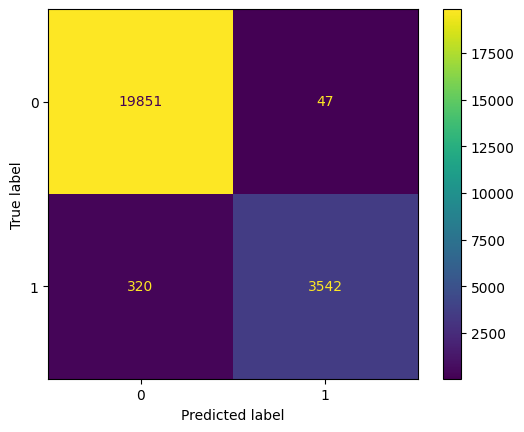

In [204]:
preds = rf_revised.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf_revised.classes_)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_revised.classes_)
display.plot(values_format='')
plt.show()

The confusion matrix demonstrates the model's ability to predict the target variable's majority class with great precision and specificity. It also shows its largest drawback with false negatives. In sum, it is great at classifying legitimate transactions, and catches the vast majority (~91.5%) of fraudulent transactions. From a business standpoint, this may be costly as fraud is going undetected, but could be considered preferable to too many false positives to maintain customer satisfaction and keep low resource costs e.g. fraud division resources.

Visualize champion model tree.

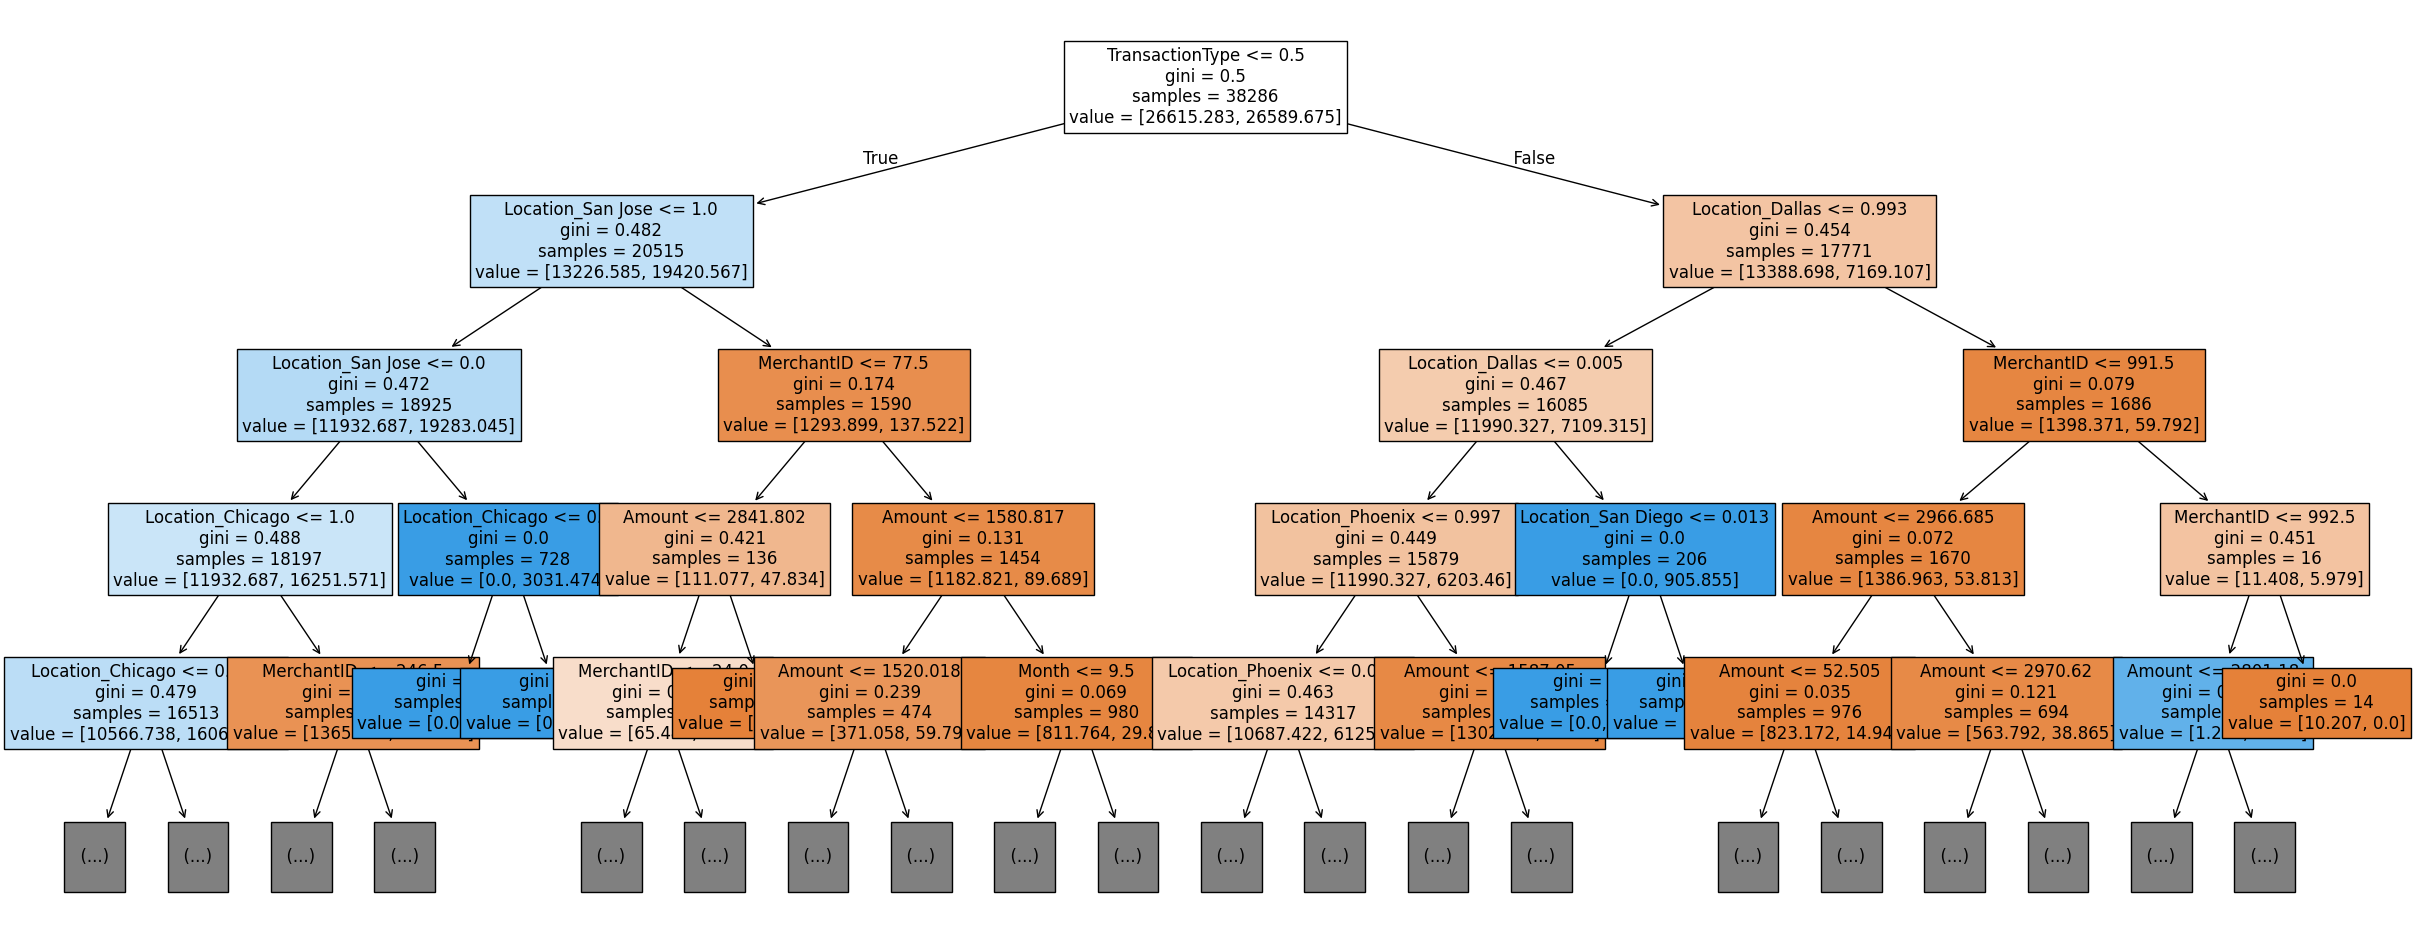

In [169]:
from sklearn.tree import plot_tree

best_tree = rf_revised.best_estimator_.estimators_[0]  # Choose the first tree

plt.figure(figsize=(30,12))
plot_tree(best_tree, fontsize=12, feature_names=X2.columns, filled = True, max_depth=4);
plt.show()

In [176]:
# Access all the decision trees in the Random Forest - note, adjusted from source
trees = rf_revised.best_estimator_.estimators_

tree_depths = [tree.get_depth() for tree in trees]

print(f"Depth of each tree: {tree_depths}")
print(f"Average tree depth: {sum(tree_depths) / len(tree_depths):.2f}")
print(f"Max tree depth: {max(tree_depths)}")
print(f"Min tree depth: {min(tree_depths)}")

Depth of each tree: [34, 32, 32, 37, 33, 34, 34, 32, 36, 35, 36, 35, 37, 33, 33, 34, 37, 34, 35, 35, 34, 36, 37, 34, 33, 36, 40, 35, 35, 35, 35, 33, 33, 32, 32, 35, 34, 32, 35, 37, 37, 33, 36, 38, 37, 35, 33, 36, 34, 34, 32, 36, 33, 32, 33, 36, 30, 36, 34, 33, 36, 35, 35, 31, 36, 32, 36, 40, 33, 36, 36, 35, 37, 37, 34, 36, 34, 32, 40, 35, 32, 35, 34, 36, 36, 36, 34, 35, 33, 31, 33, 34, 37, 37, 37, 33, 35, 35, 36, 36, 35, 38, 37, 36, 32, 35, 33, 35, 38, 35, 37, 36, 32, 36, 33, 35, 34, 38, 37, 33, 37, 39, 33, 35, 38, 33, 37, 36, 37, 37, 38, 33, 36, 34, 36, 34, 35, 36, 34, 31, 31, 35, 31, 38, 36, 35, 35, 32, 33, 34, 32, 38, 33, 36, 33, 34, 39, 37, 33, 33, 35, 34, 39, 34, 35, 33, 32, 36, 33, 38, 37, 33, 35, 36, 34, 34, 35, 39, 35, 36, 35, 36, 34, 35, 33, 35, 33, 33, 33, 40, 34, 34, 38, 34, 37, 36, 33, 36, 35, 32]
Average tree depth: 34.85
Max tree depth: 40
Min tree depth: 30


The ideal depth appears to be significantly higher than estimated for the given hyperparameter combinations (approx. 35). Adjust max_depth param in plot_tree to visualize.

Visualize feature importance.

In [ ]:
rf_revised_importances = pd.DataFrame(rf_revised.best_estimator_.feature_importances_, columns=['gini_importance'], index=X2.columns)

rf_revised_importances = rf_revised_importances.sort_values(by='gini_importance', ascending=False)

In [128]:
permutation_importances = permutation_importance(rf_revised.best_estimator_, X_test, y_test, scoring="f1", n_repeats=10, random_state=42)

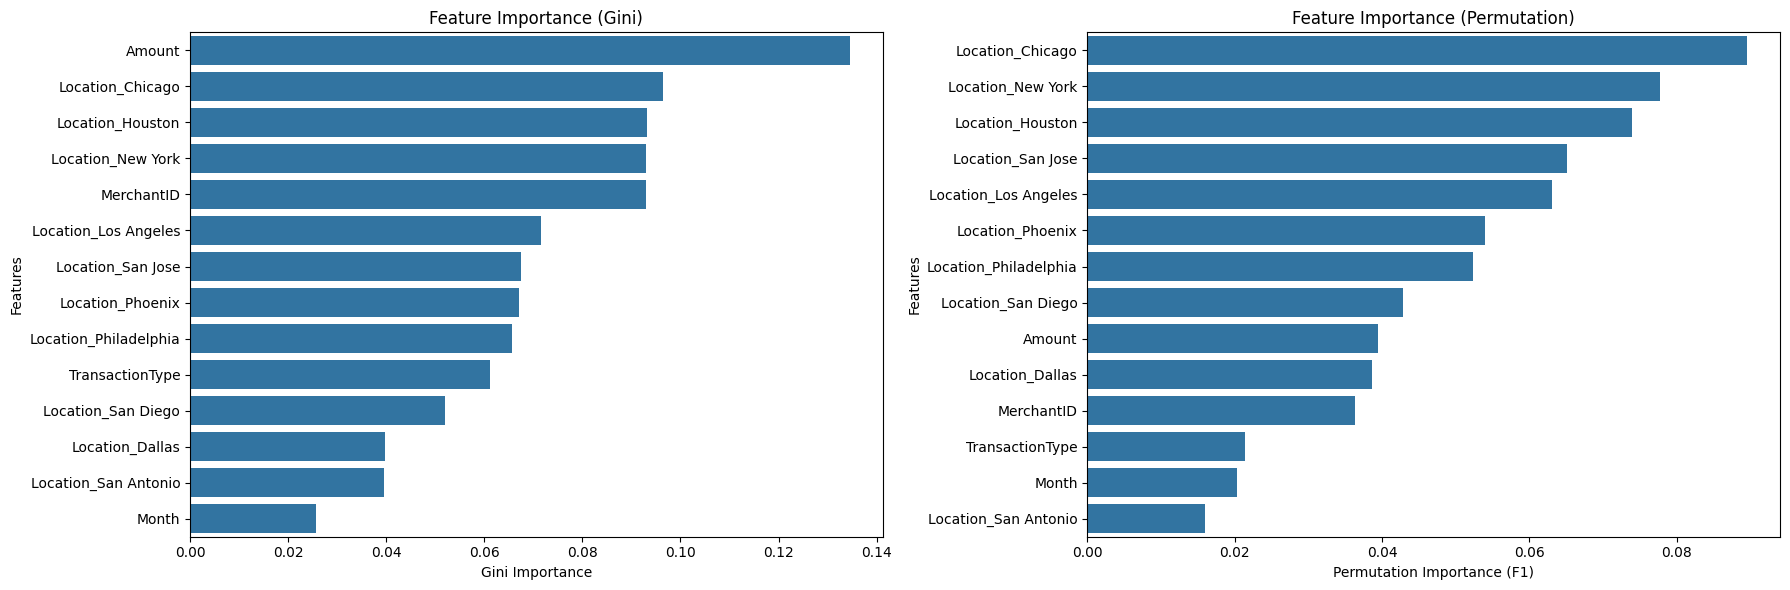

In [ ]:
perm_importances_df = pd.DataFrame({"Feature": X_test.columns,"Permutation Importance": permutation_importances.importances_mean
}).sort_values(by="Permutation Importance", ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Gini importance plot
sns.barplot(data=rf_revised_importances, x="gini_importance", y=rf_revised_importances.index, ax=ax[0], orient="h")
ax[0].set_title("Feature Importance (Gini)")
ax[0].set_xlabel("Gini Importance")
ax[0].set_ylabel("Features")

# Permutation importance plot 
sns.barplot(data=perm_importances_df, x="Permutation Importance", y="Feature", ax=ax[1], orient="h")
ax[1].set_title("Feature Importance (Permutation)")
ax[1].set_xlabel("Permutation Importance (F1)")
ax[1].set_ylabel("Features")

plt.tight_layout()
plt.show()


Contrast between feature importance demonstrated by gini and permutation importancs demonstrates the model valuing 'Amount' during model construction, but relying much more on location values to make predictions. Location seemed a good indicator in the analysis stage, and the model agreed.

It is surprising is that San Diego had the second most fraudulent transactions, while Chicago had the sixth most, but Chicago is of significantly greater importance by both metrics. Counterintuitive, may act as a sort of 'baseline' indicator, wherein having a relatively moderate amount of fraud allowed it to act as key decision node near the root of the tree? 

Speculate and/or apply potential model improvements.

In [ ]:
y_pred_proba = rf_revised.best_estimator_.predict_proba(X_test)[:, 1]  # for pos. class -> row 0 would select valid transactions
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]  # Test prediction thresholds
results = []

for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba > threshold).astype(int)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    results.append((threshold, precision, recall, f1))

# Convert to a DataFrame for better visualization
import pandas as pd
threshold_results = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1"])
threshold_results

,Threshold,Precision,Recall,F1
0,0.05,0.659095,0.961678,0.782142
1,0.10,0.795655,0.957794,0.869228
2,0.15,0.864662,0.952874,0.906627
3,0.20,0.908280,0.948731,0.928065
4,0.25,0.935591,0.944070,0.939812
5,0.30,0.952731,0.939410,0.946023
6,0.35,0.965250,0.935008,0.949888
7,0.40,0.975014,0.929570,0.951750
8,0.45,0.981858,0.924909,0.952533
9,0.50,0.986904,0.917141,0.950745


By altering the threshold for classification of the target variable classes, simple optimization of precision and recall is possible. Can visualize the relationship to easily identify an approximate ideal threshold point for classifying transactions as fraud. Want to increase recall, the weakest model metric, but must consider the returns (decreasing precision) of doing so in the context of this model.

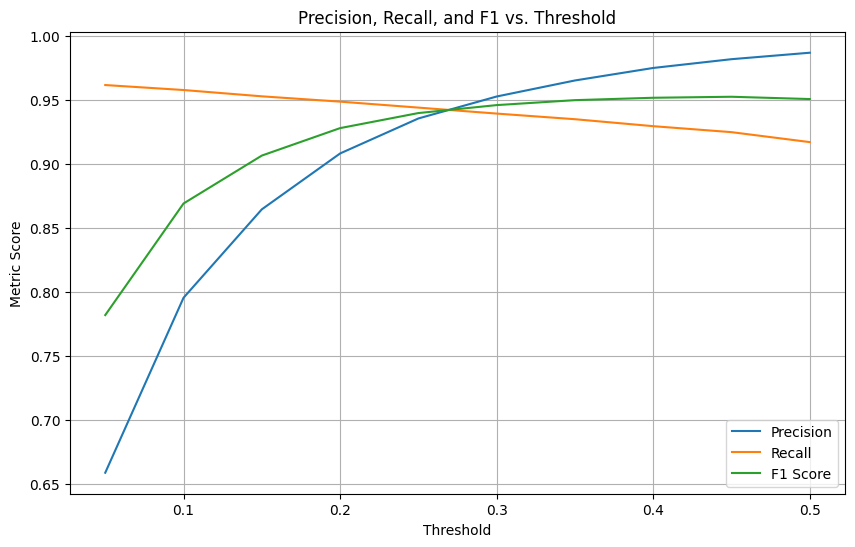

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(threshold_results["Threshold"], threshold_results["Precision"], label="Precision")
plt.plot(threshold_results["Threshold"], threshold_results["Recall"], label="Recall")
plt.plot(threshold_results["Threshold"], threshold_results["F1"], label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("Precision, Recall, and F1 vs. Threshold")
plt.legend()
plt.grid()
plt.show()


Evident that ~0.275 is the ideal threshold to maximize correct target variable classification. A viable future model improvement, presuming management approves the sacrifice of the precision metric for the sake of higher recall.

In [ ]:
optimal_threshold = 0.275  # Example threshold based on visual analysis
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

# Recalculate metrics
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)
f1_optimal = f1_score(y_test, y_pred_optimal)

print(f"Near-optimal threshold: {optimal_threshold}")
print(f"Precision: {precision_optimal:.3f}")
print(f"Recall: {recall_optimal:.3f}")
print(f"F1 Score: {f1_optimal:.3f}")


Near-optimal threshold: 0.275
Precision: 0.945
Recall: 0.941
F1 Score: 0.943


Feature engineering may provide an improvement to model performance. Examples include:
* transaction_frequency - observe spending sprees, create a ratio between TransactionDate counts by MerchantID. Fraud collusion?
* transaction_deviance - compute average Amount per given MerchantID, generate a score based on a transaction's Amount relative to the average

Generating new features like this may lead to better representations of trends within the dataset, particularly temporal or aggregate type features, that may otherwise be 'hidden' during model construction.

It is likely that further upsampling of the minority class, or fraudulent transactions, would lead to greater recall as a result of elimination of the class imbalance. This issue may be compounded by feature overlap in the uniform dataset.

Additionally, may see miniscule benefits of normalizing features like Amount to account for outliers. Benefits may be minimized due to uniform distribution of Amount values.

#### Final Note and Main Draws

A successful model was generated to predict credit card fraud with ~91.5% recall and an f1 score of ~95% in a synthetic dataset with uniformly distributed data. This model employs the use of common data science tools like cross validation, one hot encoding, upsampling, and gradient boosting and random forest models among other tools. Feature selection was conducted following the guidance of appropriate visualizations, and various parameter conditions and scoring metrics were tested to handle inconsistencies within the dataset. These included a significant class imbalance in the the target variable and uniform distributions amongst predictor variables.

A critique of the model may be that upsampling was performed after the data split. Testing data was upsampled, lowering its real world value. With the initial 99:1 class imbalance of the target variable, without expending significant computing resources, upsampling was necessary for this model. To maintain a degree of imbalance, the upsampling was conducted up to 80:20. This has the added benefit of simplifying hyperparameter tuning with cross validation. The cross validation and hyperparameter definitions were designed to prevent overfitting, which should help nullify the risk of overfitting from synthetic upsampling by adding elements of randomness. Combined with the use of a third validation split, the model should be quite robust. It is said that a valid model, trained with synthetic data or not, is more beneficial in practice than one with poor performance.

A clear path forward is presented to increase model performance (metrics), outside of expending significant computational power;
* Feature engineering: generate the previously described transaction_frequency and transaction_deviance features
* Balance classes: ideally to a near 50:50 split for maximal performance, and apply further penalizations to false negatives like custom class_weights and refit the model to the recall metric
* Adjust classification thresholds: can directly optimize precision and recall this way to maximize model performance for either metric